In [89]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO


ROOT = Path().resolve()
SRC_DIR = ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from utils_LF import evaluate_yolo_predictions
from utils_RGBTF import map_rgb_to_thermal  
from utils_results import save_results_to_txt

In [91]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["ULTRALYTICS_IGNORE_MULTIPROCESS"] = "1"

In [92]:
model_rgb   = YOLO("runs/detect/wildlife_rgb_v8n_cpu5/weights/best.pt")
model_t     = YOLO("runs/detect/wildlife_t_v8n_cpu/weights/best.pt")
model_rgbt  = YOLO("runs/detect/wildlife_rgbt_v8n_cpu3/weights/best.pt")
model_hst = YOLO("runs/detect/wildlife_hst9/weights/best.pt")
model_gst = YOLO("runs/detect/wildlife_gst/weights/best.pt")

In [93]:
VAL_RGB_DIR   = ROOT / "data" / "format_rgb"   / "images" / "val"
VAL_T_DIR     = ROOT / "data" / "format_t"     / "images" / "val"
VAL_RGBT_DIR  = ROOT / "data" / "format_rgbt"  / "images" / "val"

GT_VAL_DIR    = ROOT / "data" / "format_rgb"   / "labels" / "val"

PRED_RGB_DIR   = ROOT / "runs_wildlife" / "yolo_rgb"   / "preds"
PRED_T_DIR     = ROOT / "runs_wildlife" / "yolo_t"     / "preds"
PRED_RGBT_DIR  = ROOT / "runs_wildlife" / "yolo_rgbt"  / "preds"

VAL_HST_DIR  = ROOT / "data" / "format_hst" / "images" / "val"
VAL_GST_DIR  = ROOT / "data" / "format_gst" / "images" / "val"

GT_HST_DIR   = ROOT / "data" / "format_hst" / "labels" / "val"
GT_GST_DIR   = ROOT / "data" / "format_gst" / "labels" / "val"

PRED_HST_DIR = ROOT / "runs_wildlife" / "yolo_hst" / "preds"
PRED_GST_DIR = ROOT / "runs_wildlife" / "yolo_gst" / "preds"

PRED_LF_VAL_DIR = ROOT / "runs" / "late_fusion"   / "preds_val"
PRED_MF_VAL_DIR = ROOT / "runs" / "middle_fusion" / "preds_val"

for d in [PRED_RGB_DIR, PRED_T_DIR, PRED_RGBT_DIR, PRED_HST_DIR, PRED_GST_DIR, PRED_LF_VAL_DIR, PRED_MF_VAL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

In [94]:
rgb_imgs = sorted(
    list(VAL_RGB_DIR.glob("*.jpg")) +
    list(VAL_RGB_DIR.glob("*.JPG")) +
    list(VAL_RGB_DIR.glob("*.png")) +
    list(VAL_RGB_DIR.glob("*.PNG"))
)

print("YOLO-RGB: imágenes val =", len(rgb_imgs))

for img_path in rgb_imgs:
    res = model_rgb(str(img_path), imgsz=640, device="cpu", verbose=False)[0]
    save_results_to_txt(res, img_path, PRED_RGB_DIR)

print("Predicciones YOLO-RGB guardadas en", PRED_RGB_DIR)


YOLO-RGB: imágenes val = 64
Predicciones YOLO-RGB guardadas en C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\runs_wildlife\yolo_rgb\preds


In [95]:
print("YOLO-T: generando predicciones térmicas mapeadas a nombres RGB...")

for img_rgb_path in rgb_imgs:
    t_path = map_rgb_to_thermal(img_rgb_path, VAL_T_DIR)
    if t_path is None:
        print(f"[WARN] No térmica para {img_rgb_path.name}, salto.")
        continue

    res_t = model_t(str(t_path), imgsz=640, device="cpu", verbose=False)[0]
    save_results_to_txt(res_t, img_rgb_path, PRED_T_DIR)

print("Predicciones YOLO-T guardadas en", PRED_T_DIR)


YOLO-T: generando predicciones térmicas mapeadas a nombres RGB...
Predicciones YOLO-T guardadas en C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\runs_wildlife\yolo_t\preds


In [96]:
print("YOLO-RGBT (early fusion): generando predicciones...")

for img_rgb_path in rgb_imgs:
    img_rgbt_path = VAL_RGBT_DIR / img_rgb_path.name
    if not img_rgbt_path.exists():
        print(f"[WARN] No fusionada para {img_rgb_path.name}, salto.")
        continue

    res_rgbt = model_rgbt(str(img_rgbt_path), imgsz=640, device="cpu", verbose=False)[0]
    save_results_to_txt(res_rgbt, img_rgb_path, PRED_RGBT_DIR)

print("Predicciones YOLO-RGBT guardadas en", PRED_RGBT_DIR)


YOLO-RGBT (early fusion): generando predicciones...
Predicciones YOLO-RGBT guardadas en C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\runs_wildlife\yolo_rgbt\preds


In [97]:
hst_imgs = sorted(
    list(VAL_HST_DIR.glob("*.jpg")) +
    list(VAL_HST_DIR.glob("*.JPG")) +
    list(VAL_HST_DIR.glob("*.png")) +
    list(VAL_HST_DIR.glob("*.PNG"))
)

print("YOLO-HST: imágenes val =", len(hst_imgs))

for img_path in hst_imgs:
    res = model_hst(str(img_path), imgsz=640, device="cpu", verbose=False)[0]

    save_results_to_txt(res, img_path, PRED_HST_DIR)

print("Predicciones YOLO-HST guardadas en", PRED_HST_DIR)


YOLO-HST: imágenes val = 64
Predicciones YOLO-HST guardadas en C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\runs_wildlife\yolo_hst\preds


In [98]:
gst_imgs = sorted(
    list(VAL_GST_DIR.glob("*.jpg")) +
    list(VAL_GST_DIR.glob("*.JPG")) +
    list(VAL_GST_DIR.glob("*.png")) +
    list(VAL_GST_DIR.glob("*.PNG"))
)

print("YOLO-GST: imágenes val =", len(gst_imgs))

for img_path in gst_imgs:
    res = model_gst(str(img_path), imgsz=640, device="cpu", verbose=False)[0]
    save_results_to_txt(res, img_path, PRED_GST_DIR)

print("Predicciones YOLO-GST guardadas en", PRED_GST_DIR)


YOLO-GST: imágenes val = 64
Predicciones YOLO-GST guardadas en C:\Users\isiva\OneDrive\Documents\GitHub\TP-Final-Vision\runs_wildlife\yolo_gst\preds


In [ ]:
NUM_CLASSES = 3
GT_DIR = GT_VAL_DIR  

iou_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

MODELS = {
    "YOLO-RGB":   (PRED_RGB_DIR,  GT_VAL_DIR),
    "YOLO-T":     (PRED_T_DIR,    GT_VAL_DIR),
    "YOLO-RGBT":  (PRED_RGBT_DIR, GT_VAL_DIR),
    "YOLO-HST":   (PRED_HST_DIR,  GT_HST_DIR),
    "YOLO-GST":   (PRED_GST_DIR,  GT_GST_DIR),
    "YOLO-Late":   (PRED_LF_VAL_DIR, GT_VAL_DIR),
    "YOLO-Middle": (PRED_MF_VAL_DIR, GT_VAL_DIR),
}

map_curves = {name: [] for name in MODELS.keys()}

for name, (pred_dir, gt_dir) in MODELS.items():
    print(f"Evaluando {name}...")
    for iou in iou_list:
        metrics = evaluate_yolo_predictions(
            pred_dir=pred_dir,
            gt_dir=gt_dir,
            num_classes=NUM_CLASSES,
            iou_threshold=iou
        )
        map_curves[name].append(metrics["mAP"])


Evaluando YOLO-RGB...
Evaluando YOLO-T...
Evaluando YOLO-RGBT...
Evaluando YOLO-HST...
Evaluando YOLO-GST...
Evaluando YOLO-Late...
Evaluando YOLO-Middle...


,IoU 0.1,IoU 0.2,IoU 0.3,IoU 0.4,IoU 0.5,IoU 0.6,IoU 0.7,IoU 0.8,IoU 0.9
YOLO-RGB,0.789889,0.789889,0.778699,0.766735,0.766735,0.721458,0.491895,0.155123,0.023810
YOLO-T,0.882288,0.882288,0.882288,0.882288,0.818109,0.751750,0.600439,0.170421,0.002290
YOLO-RGBT,0.983219,0.983219,0.983219,0.983219,0.982858,0.927285,0.772671,0.320997,0.038029
YOLO-HST,0.809580,0.809580,0.809580,0.809580,0.809580,0.723023,0.563400,0.197235,0.002701
YOLO-GST,0.904251,0.904251,0.904251,0.904251,0.895475,0.865231,0.661339,0.232050,0.015713
YOLO-Late,0.900833,0.900833,0.901242,0.890834,0.868726,0.847609,0.615741,0.170766,0.009921
YOLO-Middle,0.918489,0.918489,0.918711,0.918711,0.911881,0.911881,0.718841,0.292460,0.010681


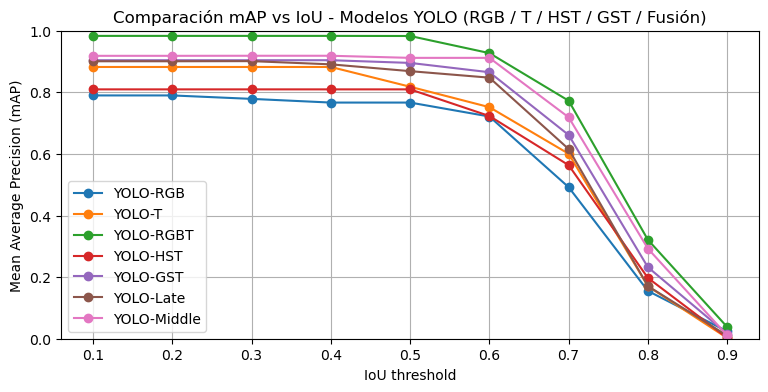

In [100]:
df_table = pd.DataFrame(
    {name: map_curves[name] for name in map_curves.keys()},
    index=[f"IoU {iou:.1f}" for iou in iou_list]
).T

display(df_table)


plt.figure(figsize=(9,4))

for name, mAPs in map_curves.items():
    plt.plot(iou_list, mAPs, marker="o", label=name)

plt.xlabel("IoU threshold")
plt.ylabel("Mean Average Precision (mAP)")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.title("Comparación mAP vs IoU - Modelos YOLO (RGB / T / HST / GST / Fusión)")
plt.show()



In [ ]:
GT_RGB_TEST  = ROOT / "data" / "format_rgb"  / "labels" / "test"
GT_T_TEST    = ROOT / "data" / "format_t"    / "labels" / "test"
GT_RGBT_TEST = ROOT / "data" / "format_rgbt" / "labels" / "test"
GT_HST_TEST  = ROOT / "data" / "format_hst"  / "labels" / "test"
GT_GST_TEST  = ROOT / "data" / "format_gst"  / "labels" / "test"

IMG_RGB_TEST  = ROOT / "data" / "format_rgb"  / "images" / "test"
IMG_T_TEST    = ROOT / "data" / "format_t"    / "images" / "test"
IMG_RGBT_TEST = ROOT / "data" / "format_rgbt" / "images" / "test"
IMG_HST_TEST  = ROOT / "data" / "format_hst"  / "images" / "test"
IMG_GST_TEST  = ROOT / "data" / "format_gst"  / "images" / "test"

PRED_RGB_TEST   = ROOT / "runs_wildlife" / "yolo_rgb_test"  / "preds"
PRED_T_TEST     = ROOT / "runs_wildlife" / "yolo_t_test"    / "preds"
PRED_RGBT_TEST  = ROOT / "runs_wildlife" / "yolo_rgbt_test" / "preds"
PRED_HST_TEST   = ROOT / "runs_wildlife" / "yolo_hst_test"  / "preds"
PRED_GST_TEST   = ROOT / "runs_wildlife" / "yolo_gst_test"  / "preds"

PRED_LATE_TEST  = ROOT / "runs" / "late_fusion"   / "preds_test"
PRED_MID_TEST   = ROOT / "runs" / "middle_fusion" / "preds_test"

In [ ]:
MODELS_TEST = {
    "YOLO-RGB":    (PRED_RGB_TEST,   GT_RGB_TEST),
    "YOLO-T":      (PRED_T_TEST,     GT_T_TEST),
    "YOLO-RGBT":   (PRED_RGBT_TEST,  GT_RGBT_TEST),

    "YOLO-HST":    (PRED_HST_TEST,   GT_HST_TEST),
    "YOLO-GST":    (PRED_GST_TEST,   GT_GST_TEST),

    "YOLO-Late":   (PRED_LATE_TEST,  GT_RGB_TEST),   
    "YOLO-Middle": (PRED_MID_TEST,   GT_RGBT_TEST),   
}

In [ ]:
map_curves_test = {name: [] for name in MODELS_TEST}

for name, (pred_dir, gt_dir) in MODELS_TEST.items():
    print(f"Evaluando TEST – {name}")
    for iou in iou_list:
        metrics = evaluate_yolo_predictions(
            pred_dir=pred_dir,
            gt_dir=gt_dir,
            num_classes=NUM_CLASSES,
            iou_threshold=iou,
        )
        map_curves_test[name].append(metrics["mAP"])

Evaluando TEST – YOLO-RGB
Evaluando TEST – YOLO-T
Evaluando TEST – YOLO-RGBT
Evaluando TEST – YOLO-HST
Evaluando TEST – YOLO-GST
Evaluando TEST – YOLO-Late
Evaluando TEST – YOLO-Middle


,IoU 0.1,IoU 0.2,IoU 0.3,IoU 0.4,IoU 0.5,IoU 0.6,IoU 0.7,IoU 0.8,IoU 0.9
YOLO-RGB,0.789153,0.789153,0.789153,0.789153,0.787588,0.773129,0.479269,0.353751,0.029293
YOLO-T,0.929293,0.929293,0.929293,0.929293,0.929293,0.872054,0.567821,0.299682,0.018013
YOLO-RGBT,0.989899,0.989899,0.989899,0.989899,0.988673,0.934997,0.774914,0.434070,0.040404
YOLO-HST,0.916719,0.916719,0.916719,0.916719,0.916719,0.854509,0.704236,0.356624,0.058586
YOLO-GST,0.926837,0.926837,0.926837,0.926837,0.926837,0.908113,0.623577,0.399920,0.010695
YOLO-Late,0.963548,0.963548,0.963548,0.963548,0.963548,0.909002,0.510135,0.318631,0.016162
YOLO-Middle,0.987714,0.987714,0.987714,0.987714,0.987714,0.991863,0.742448,0.224554,0.040741


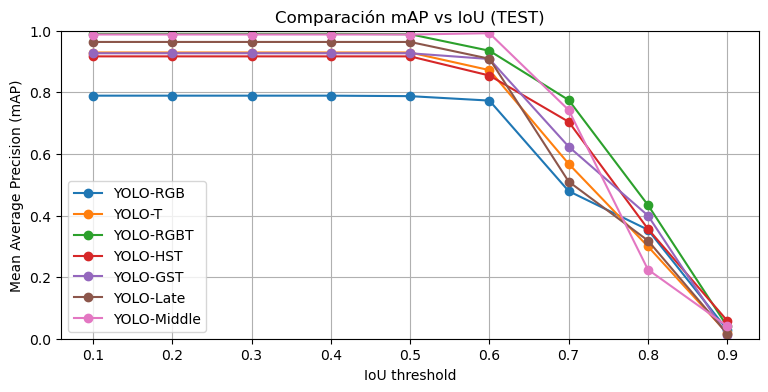

In [ ]:
df_test = pd.DataFrame(
    map_curves_test,
    index=[f"IoU {iou:.1f}" for iou in iou_list]
).T

display(df_test)
df_test.to_csv("runs/mAP_table_test.csv", float_format="%.5f")

plt.figure(figsize=(9,4))

for name, mAPs in map_curves_test.items():
    plt.plot(iou_list, mAPs, marker="o", label=name)

plt.xlabel("IoU threshold")
plt.ylabel("Mean Average Precision (mAP)")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.title("Comparación mAP vs IoU (TEST)")
plt.show()